# 1차

In [1]:
import konlpy
import numpy as np
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization

df = pd.read_excel('data.xlsx')

df_clean = df.dropna()

df_clean2 = df_clean.drop_duplicates(subset=['document'])

df_clean3 = df_clean2.copy()
df_clean3['document'] = df_clean3['document'].replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True)
df_clean3['document'] = df_clean3['document'].replace('^ +', '', regex=True)
df_clean3['document'] = df_clean3['document'].replace('', np.nan)

df_clean4 = df_clean3.dropna()
df_clean4 = df_clean4.reset_index(drop=True)

from konlpy.tag import Okt
from tqdm import tqdm

tk = Okt()
불용어 = set('은 는 이 가 를 에 에게 의 고 을 으로 만 라서 하다 그리고 하지만 그래서 저 그 것 들 도 아니 또는 그러나 더 좀 그런 있는 하는 해서 했던 하며'.split())

X_data = []
for 문장 in tqdm(df_clean4['document']):
    토큰화_된_문장 = tk.morphs(문장)
    불용어_처리_된_문장 = [단어 for 단어 in 토큰화_된_문장 if 단어 not in 불용어]
    X_data.append(' '.join(불용어_처리_된_문장))

X_data

tk_i = Tokenizer()
tk_i.fit_on_texts(X_data)
w_n = len([d for d in list(tk_i.word_counts.items()) if d[1]>4])

tk_out = Tokenizer(num_words=w_n)
tk_out.fit_on_texts(X_data)

c_X_data = tk_out.texts_to_sequences(X_data)

100%|███████████████████████████████████████████████████████████████████████████| 36737/36737 [03:03<00:00, 200.46it/s]


Epoch 1/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6494 - loss: 0.8760
Epoch 1: val_loss improved from inf to 0.42245, saving model to best_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 211s 414ms/step - accuracy: 0.6496 - loss: 0.8755 - val_accuracy: 0.8161 - val_loss: 0.4224
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8581 - loss: 0.3548
Epoch 2: val_loss improved from 0.42245 to 0.41069, saving model to best_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 190s 387ms/step - accuracy: 0.8581 - loss: 0.3549 - val_accuracy: 0.8189 - val_loss: 0.4107
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8821 - loss: 0.2978
Epoch 3: val_loss did not improve from 0.41069
460/460 ━━━━━━━━━━━━━━━━━━━━ 210s 404ms/step - accuracy: 0.8821 - loss: 0.2978 - val_accuracy: 0.8144 - val_loss: 0.4386
Epoch 4/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9028 - loss: 0.2539
Epoch 4: val_loss did not improve from 0.41069
460/460 ━━━━━━━━━━━━━━━━━

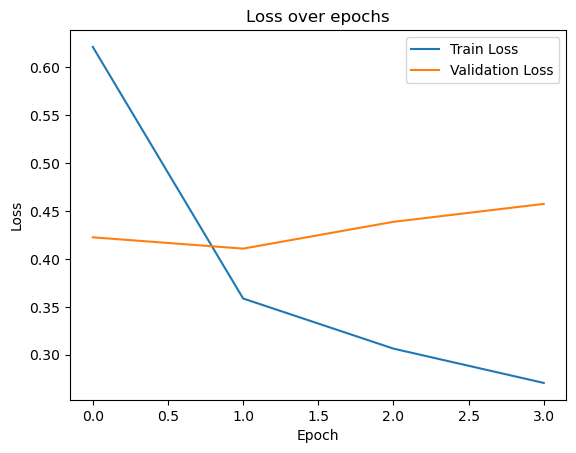

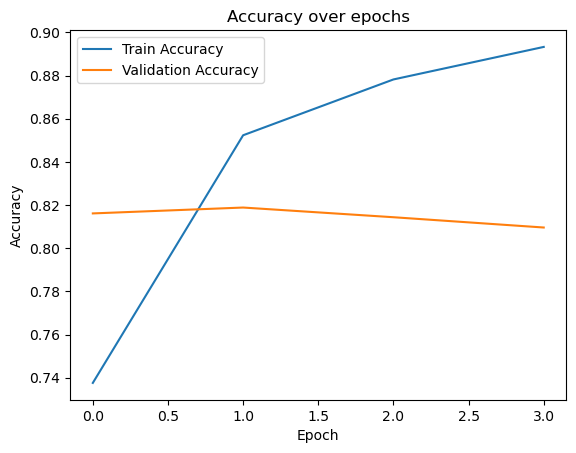

In [4]:
MAX_WORDS = w_n
EMBEDDING_DIM = 100
max_len = 100

X = pad_sequences(c_X_data, maxlen=max_len, padding='post')
y = df_clean4['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)


# 6) 모델 학습
from sklearn.utils import class_weight

# 클래스 가중치 자동 계산
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# 모델 학습 시 적용
hy = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint], class_weight=class_weights)

# 7) 학습 손실과 검증 손실 그래프
plt.plot(hy.history['loss'], label='Train Loss')
plt.plot(hy.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 8) 학습 정확도와 검증 정확도 그래프
plt.plot(hy.history['accuracy'], label='Train Accuracy')
plt.plot(hy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
# 1) 검증 데이터 예측 (확률)
y_val_pred_prob = model.predict(X_val)

# 2) 최적 threshold 찾기 (F1 기준)
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.3, 0.7, 0.01):
    pred = (y_val_pred_prob > t).astype(int).reshape(-1)
    score = f1_score(y_val, pred)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"✅ F1 기준 최적 threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")

# 3) 해당 threshold로 최종 평가
y_val_pred = (y_val_pred_prob > best_thresh).astype(int).reshape(-1)

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"📉 Validation Loss: {val_loss:.4f}")
print(f"📈 Validation Accuracy: {val_acc:.4f}")

precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"📊 Precision: {precision:.4f}")
print(f"📊 Recall: {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")

# 4) 테스트 데이터 불러오기 및 전처리
test_df = pd.read_excel("submit.xlsx")
test_texts = test_df['document']

test_tokens = []
for 문장 in test_texts:
    토큰화 = tk.morphs(문장)
    불용어제거 = [단어 for 단어 in 토큰화 if 단어 not in 불용어]
    test_tokens.append(' '.join(불용어제거))

test_seq = tk_out.texts_to_sequences(test_tokens)
X_test = pad_sequences(test_seq, maxlen=max_len, padding='post')

# 5) 테스트 데이터 예측 (최적 threshold 적용)
pred_prob = model.predict(X_test)
pred_label = (pred_prob > best_thresh).astype(int).reshape(-1)

# 6) 결과 저장
test_df['label'] = pred_label
test_df.to_excel("result.xlsx", index=False)
print("📁 결과 저장 완료 → result.xlsx")

# 7) 예측 분포 확인
labels, counts = np.unique(pred_label, return_counts=True)
print(f"📦 예측 분포: {dict(zip(labels, counts))}")

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step
✅ F1 기준 최적 threshold: 0.33, F1: 0.8191
📉 Validation Loss: 0.4107
📈 Validation Accuracy: 0.8189
📊 Precision: 0.7701
📊 Recall: 0.8747
📊 F1-Score: 0.8191
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step
📁 결과 저장 완료 → result.xlsx
📦 예측 분포: {0: 5214, 1: 7299}


# 2차

100%|███████████████████████████████████████████████████████████████████████████| 36737/36737 [04:20<00:00, 141.03it/s]


Epoch 1/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6515 - loss: 0.8770
Epoch 1: val_loss improved from inf to 0.41542, saving model to best_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 277s 554ms/step - accuracy: 0.6517 - loss: 0.8764 - val_accuracy: 0.8168 - val_loss: 0.4154
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8473 - loss: 0.3782
Epoch 2: val_loss improved from 0.41542 to 0.40224, saving model to best_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 205s 430ms/step - accuracy: 0.8473 - loss: 0.3782 - val_accuracy: 0.8243 - val_loss: 0.4022
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8686 - loss: 0.3306
Epoch 3: val_loss did not improve from 0.40224
460/460 ━━━━━━━━━━━━━━━━━━━━ 214s 455ms/step - accuracy: 0.8685 - loss: 0.3306 - val_accuracy: 0.8174 - val_loss: 0.4294
Epoch 4/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8781 - loss: 0.3088
Epoch 4: val_loss did not improve from 0.40224
460/460 ━━━━━━━━━━━━━━━━━

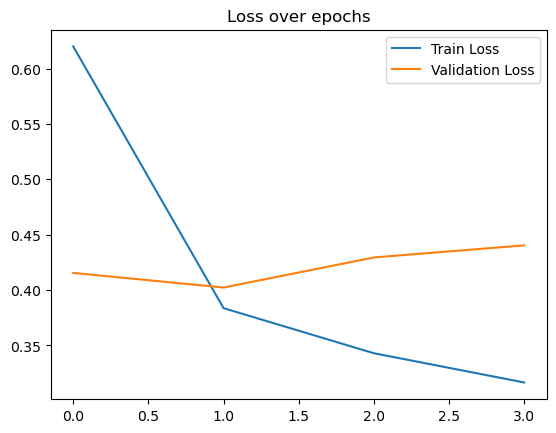

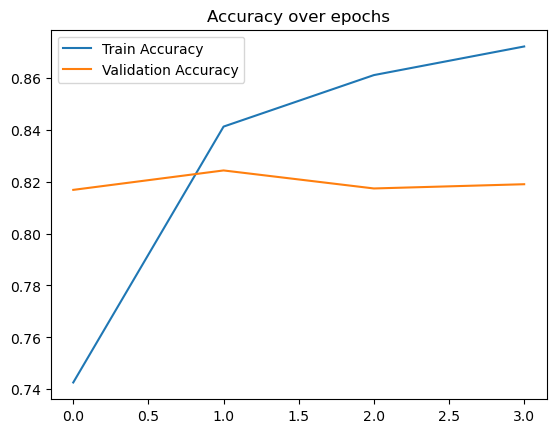

230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
✅ F1 기준 최적 threshold: 0.44, F1: 0.8257
📉 Validation Loss: 0.4022
📈 Validation Accuracy: 0.8243
📊 Precision: 0.8025
📊 Recall: 0.8503
📊 F1-Score: 0.8257
392/392 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step
📁 결과 저장 완료 → result.xlsx
📦 예측 분포: {0: 5692, 1: 6821}


In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 1) 데이터 로드 및 정제
df = pd.read_excel('data.xlsx').dropna().drop_duplicates(subset=['document'])
df['document'] = df['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True).str.strip()
df = df[df['document'] != ''].reset_index(drop=True)

# 2) 형태소 분석 + 의미있는 품사 필터링
tk = Okt()
불용어 = set('은 는 이 가 를 에 에게 의 고 을 으로 만 라서 하다 그리고 하지만 그래서 저 그 것 들 도 아니 또는 그러나 더 좀 그런 있는 하는 해서 했던 하며'.split())
의미_품사 = {'Noun', 'Adjective', 'Verb'}

X_data = []
for 문장 in tqdm(df['document']):
    토큰화 = tk.pos(문장, stem=True)
    정제 = [단어 for 단어, 품사 in 토큰화 if 단어 not in 불용어 and 품사 in 의미_품사]
    X_data.append(' '.join(정제))

# 3) 토크나이저 및 시퀀싱
tk_i = Tokenizer()
tk_i.fit_on_texts(X_data)
w_n = len([d for d in tk_i.word_counts.items() if d[1] > 4])

tk_out = Tokenizer(num_words=w_n)
tk_out.fit_on_texts(X_data)
seq = tk_out.texts_to_sequences(X_data)

MAX_WORDS = w_n
EMBEDDING_DIM = 100
max_len = 100

X = pad_sequences(seq, maxlen=max_len, padding='post')
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4) 모델 정의
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5) 콜백 및 클래스 가중치
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# 6) 모델 학습
hy = model.fit(X_train, y_train, epochs=20, batch_size=64,
               validation_data=(X_val, y_val),
               callbacks=[early_stopping, model_checkpoint],
               class_weight=class_weights)

# 7) 시각화
plt.plot(hy.history['loss'], label='Train Loss')
plt.plot(hy.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

plt.plot(hy.history['accuracy'], label='Train Accuracy')
plt.plot(hy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# 8) 최적 threshold 찾기
y_val_pred_prob = model.predict(X_val)
best_f1, best_thresh = 0, 0.5
for t in np.arange(0.3, 0.7, 0.01):
    pred = (y_val_pred_prob > t).astype(int).reshape(-1)
    score = f1_score(y_val, pred)
    if score > best_f1:
        best_f1, best_thresh = score, t
print(f"✅ F1 기준 최적 threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")

# 9) 최종 평가
y_val_pred = (y_val_pred_prob > best_thresh).astype(int).reshape(-1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"📉 Validation Loss: {val_loss:.4f}")
print(f"📈 Validation Accuracy: {val_acc:.4f}")
print(f"📊 Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"📊 Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"📊 F1-Score: {f1_score(y_val, y_val_pred):.4f}")

# 10) 테스트 예측
test_df = pd.read_excel("submit.xlsx")
test_tokens = []
for 문장 in test_df['document']:
    토큰화 = tk.pos(문장, stem=True)
    정제 = [단어 for 단어, 품사 in 토큰화 if 단어 not in 불용어 and 품사 in 의미_품사]
    test_tokens.append(' '.join(정제))

test_seq = tk_out.texts_to_sequences(test_tokens)
X_test = pad_sequences(test_seq, maxlen=max_len, padding='post')

pred_prob = model.predict(X_test)
pred_label = (pred_prob > best_thresh).astype(int).reshape(-1)
test_df['label'] = pred_label
test_df.to_excel("result.xlsx", index=False)
print("📁 결과 저장 완료 → result.xlsx")

labels, counts = np.unique(pred_label, return_counts=True)
print(f"📦 예측 분포: {dict(zip(labels, counts))}")


# 3차

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# 1) 데이터 로드 및 정제
df = pd.read_excel('data.xlsx').dropna().drop_duplicates(subset=['document'])
df['document'] = df['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True).str.strip()
df = df[df['document'] != ''].reset_index(drop=True)

# 2) 형태소 분석 + 의미있는 품사 필터링
tk = Okt()
불용어 = set('은 는 이 가 를 에 에게 의 고 을 으로 만 라서 하다 그리고 하지만 그래서 저 그 것 들 도 아니 또는 그러나 더 좀 그런 있는 하는 해서 했던 하며'.split())
의미_품사 = {'Noun', 'Adjective', 'Verb'}

X_data = []
for 문장 in tqdm(df['document']):
    토큰화 = tk.pos(문장, stem=True)
    정제 = [단어 for 단어, 품사 in 토큰화 if 단어 not in 불용어 and 품사 in 의미_품사]
    X_data.append(' '.join(정제))

# 3) 토크나이저 및 시퀀싱
tk_i = Tokenizer()
tk_i.fit_on_texts(X_data)
w_n = len([d for d in tk_i.word_counts.items() if d[1] > 4])

tk_out = Tokenizer(num_words=w_n)
tk_out.fit_on_texts(X_data)
seq = tk_out.texts_to_sequences(X_data)

# 하이퍼파라미터
MAX_WORDS = w_n
EMBEDDING_DIM = 100
max_len = 100

# 모델 구성
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_hybrid.keras', monitor='val_loss', save_best_only=True, verbose=1)

# 클래스 가중치
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# Threshold 최적화
y_val_pred_prob = model.predict(X_val)
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.3, 0.7, 0.01):
    pred = (y_val_pred_prob > t).astype(int).reshape(-1)
    score = f1_score(y_val, pred)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"✅ F1 기준 최적 threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")

# 9) 최종 평가
y_val_pred = (y_val_pred_prob > best_thresh).astype(int).reshape(-1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"📉 Validation Loss: {val_loss:.4f}")
print(f"📈 Validation Accuracy: {val_acc:.4f}")
print(f"📊 Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"📊 Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"📊 F1-Score: {f1_score(y_val, y_val_pred):.4f}")

# 10) 테스트 예측
test_df = pd.read_excel("submit.xlsx")
test_tokens = []
for 문장 in test_df['document']:
    토큰화 = tk.pos(문장, stem=True)
    정제 = [단어 for 단어, 품사 in 토큰화 if 단어 not in 불용어 and 품사 in 의미_품사]
    test_tokens.append(' '.join(정제))

test_seq = tk_out.texts_to_sequences(test_tokens)
X_test = pad_sequences(test_seq, maxlen=max_len, padding='post')

pred_prob = model.predict(X_test)
pred_label = (pred_prob > best_thresh).astype(int).reshape(-1)
test_df['label'] = pred_label
test_df.to_excel("result.xlsx", index=False)
print("📁 결과 저장 완료 → result.xlsx")

labels, counts = np.unique(pred_label, return_counts=True)
print(f"📦 예측 분포: {dict(zip(labels, counts))}")




Epoch 1/20


C:\Users\woota\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6665 - loss: 0.8534
Epoch 1: val_loss improved from inf to 0.40684, saving model to best_model_hybrid.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 227s 445ms/step - accuracy: 0.6667 - loss: 0.8528 - val_accuracy: 0.8208 - val_loss: 0.4068
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8541 - loss: 0.3607
Epoch 2: val_loss did not improve from 0.40684
460/460 ━━━━━━━━━━━━━━━━━━━━ 239s 396ms/step - accuracy: 0.8541 - loss: 0.3607 - val_accuracy: 0.8193 - val_loss: 0.4134
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8847 - loss: 0.2856
Epoch 3: val_loss did not improve from 0.40684
460/460 ━━━━━━━━━━━━━━━━━━━━ 193s 375ms/step - accuracy: 0.8846 - loss: 0.2856 - val_accuracy: 0.8172 - val_loss: 0.4204
Epoch 4/20
